# Train tagged based chunker

Instead fo writing the regex to match the exact pattern we can train chunker based on teh existing corpus.

## Training 

In [16]:
from nltk.chunk import ChunkParserI
from nltk.chunk.util import tree2conlltags,conlltags2tree
from nltk.tag import UnigramTagger,BigramTagger

# corpus
from nltk.corpus import treebank_chunk

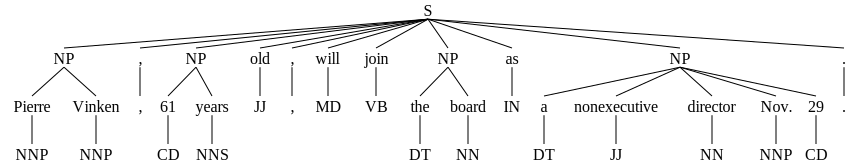

In [3]:
treebank_chunk.chunked_sents()[0]

In [4]:
print(treebank_chunk.chunked_sents()[0])

(S
  (NP Pierre/NNP Vinken/NNP)
  ,/,
  (NP 61/CD years/NNS)
  old/JJ
  ,/,
  will/MD
  join/VB
  (NP the/DT board/NN)
  as/IN
  (NP a/DT nonexecutive/JJ director/NN Nov./NNP 29/CD)
  ./.)


In [8]:
tree2conlltags(treebank_chunk.chunked_sents()[0])
#? Each chunk sent are in the form (word,tag,IOB tag)
#? IOB tag is used to specify the start and inside to  noun Phrase chunk.

[('Pierre', 'NNP', 'B-NP'),
 ('Vinken', 'NNP', 'I-NP'),
 (',', ',', 'O'),
 ('61', 'CD', 'B-NP'),
 ('years', 'NNS', 'I-NP'),
 ('old', 'JJ', 'O'),
 (',', ',', 'O'),
 ('will', 'MD', 'O'),
 ('join', 'VB', 'O'),
 ('the', 'DT', 'B-NP'),
 ('board', 'NN', 'I-NP'),
 ('as', 'IN', 'O'),
 ('a', 'DT', 'B-NP'),
 ('nonexecutive', 'JJ', 'I-NP'),
 ('director', 'NN', 'I-NP'),
 ('Nov.', 'NNP', 'I-NP'),
 ('29', 'CD', 'I-NP'),
 ('.', '.', 'O')]

In [70]:
set([iob_tag
    for chunk in treebank_chunk.chunked_sents()
    for (word,pos,iob_tag) in tree2conlltags(chunk) ])

{'B-NP', 'I-NP', 'O'}

In [12]:
def conll_tag_chunks(chunk_sents):
    tagged_sent = [tree2conlltags(tree) for tree in chunk_sents]
    return [[(t,c) for (w,t,c) in sent] for sent in tagged_sent]

#? convert the (w,pos,iob) format to (pos,iob)
#? then (pos,iob) format is used to train the Tagger that pos is used to predict the iob.

In [14]:
conll_tag_chunks(treebank_chunk.chunked_sents()[:1])

[[('NNP', 'B-NP'),
  ('NNP', 'I-NP'),
  (',', 'O'),
  ('CD', 'B-NP'),
  ('NNS', 'I-NP'),
  ('JJ', 'O'),
  (',', 'O'),
  ('MD', 'O'),
  ('VB', 'O'),
  ('DT', 'B-NP'),
  ('NN', 'I-NP'),
  ('IN', 'O'),
  ('DT', 'B-NP'),
  ('JJ', 'I-NP'),
  ('NN', 'I-NP'),
  ('NNP', 'I-NP'),
  ('CD', 'I-NP'),
  ('.', 'O')]]

In [15]:
def backoff_tagger(train_sents,tagger_classes,backoff=None):
    for cls in tagger_classes:
        backoff = cls(train_sents,backoff=backoff)
    return backoff

#? Create the Tagger that have unigram and bigram tagger

In [47]:
class TagChunker(ChunkParserI):
    def __init__(self,train_chunks,tagger_classes=[UnigramTagger,BigramTagger]) -> None:
        super().__init__()
        train_sents = conll_tag_chunks(train_chunks)
        self.tagger = backoff_tagger(train_sents,tagger_classes)
    
    def parse(self, tokens):
        if not tokens : return None
        # print(tokens)
        (word,tags) = zip(*tokens)
        # print(tags)
        #! we use the tag to predict the iob
        chunks = self.tagger.tag(tags)        
        # print(chunks)
        wtc = zip(word,chunks)
        return conlltags2tree([(w,t,c) for (w,(t,c)) in wtc])

In [48]:
len(treebank_chunk.chunked_sents())

4009

In [49]:
train_chunks = treebank_chunk.chunked_sents()[:3000]
test_chunks = treebank_chunk.chunked_sents()[3000:]

In [50]:
chunker = TagChunker(train_chunks)

In [51]:
score = chunker.accuracy(test_chunks[:1])

In [52]:
score.accuracy()

0.8888888888888888

In [53]:
score.precision()

0.75

In [54]:
score.recall()

0.75

In [55]:
from nltk.corpus import conll2000
conll_train = conll2000.chunked_sents("train.txt")
conll_test = conll2000.chunked_sents("test.txt")

In [57]:
chunker = TagChunker(conll_train)
score = chunker.accuracy(conll_test)

In [58]:
score.accuracy()

0.8950545623403762

In [59]:
score.precision(),score.recall()

(0.8114841974355675, 0.8644191676944863)